<a href="https://colab.research.google.com/github/JoshAmpofo/mlzoomcamp_2025/blob/main/HairClassifier_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# get hair dataset
!wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
!unzip data.zip

--2025-12-02 13:00:13--  https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/405934815/e712cf72-f851-44e0-9c05-e711624af985?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-02T13%3A50%3A19Z&rscd=attachment%3B+filename%3Ddata.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-02T12%3A49%3A21Z&ske=2025-12-02T13%3A50%3A19Z&sks=b&skv=2018-11-09&sig=W%2BA3874zpmWNc4aseHuCu83NzL7q0c7SvKQ1nimsGpE%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NDY4MjIxMywibmJmIjoxNzY0NjgwNDEzLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

In [5]:
# maintain reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [13]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

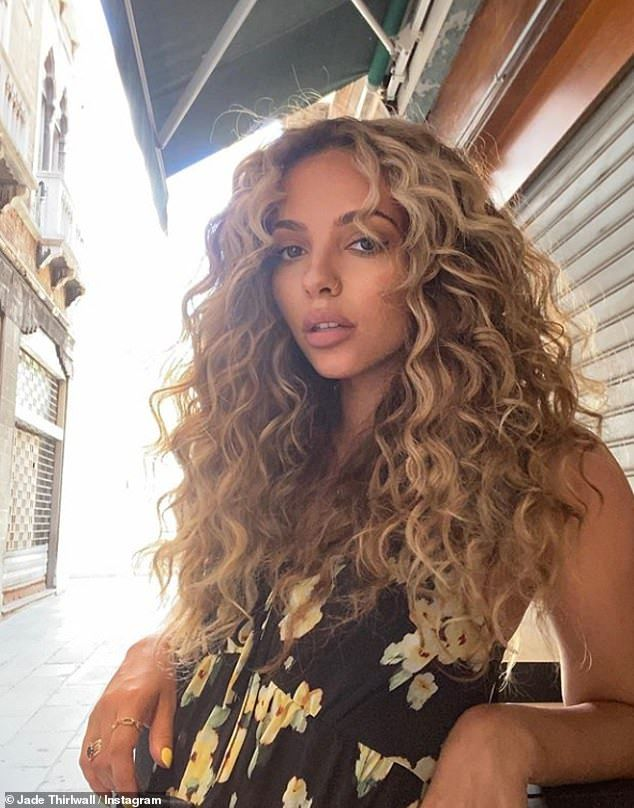

In [6]:
image = Image.open("/content/data/train/curly/0160dfee18352aa9bf5c6e617de9e07b4.jpg")
image

###**Load Dataset**

In [16]:
from torchvision import transforms, datasets

# specify transformations
input_size = 200

# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [17]:
# load dataset
train_dataset = datasets.ImageFolder("/content/data/train", transform=train_transforms)
validation_dataset = datasets.ImageFolder("/content/data/test", transform=test_transforms)

# load the dataloaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)

###**Build the CNN Model**

In [18]:
class HairClassifierCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # -- convolutional layer --
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.fc = nn.Sequential(
        nn.Linear(32 * 99 * 99, 64),
        nn.ReLU(),
        nn.Linear(64, 1) # output layer
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)

    return self.fc(x)

model = HairClassifierCNN().to(device)

In [19]:
from torchsummary import summary

summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------


In [20]:
import torch.optim as optim

optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.002,
                            momentum=0.8)
criterion = nn.BCEWithLogitsLoss()

In [22]:
# training loop
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6665, Acc: 0.6112, Val Loss: 0.6511, Val Acc: 0.6617
Epoch 2/10, Loss: 0.5702, Acc: 0.6787, Val Loss: 0.6332, Val Acc: 0.6318
Epoch 3/10, Loss: 0.5207, Acc: 0.7350, Val Loss: 0.6143, Val Acc: 0.6766
Epoch 4/10, Loss: 0.4773, Acc: 0.7600, Val Loss: 0.6049, Val Acc: 0.6617
Epoch 5/10, Loss: 0.4606, Acc: 0.7550, Val Loss: 0.7307, Val Acc: 0.5672
Epoch 6/10, Loss: 0.3954, Acc: 0.8275, Val Loss: 0.6412, Val Acc: 0.6866
Epoch 7/10, Loss: 0.2844, Acc: 0.8838, Val Loss: 0.8307, Val Acc: 0.6816
Epoch 8/10, Loss: 0.2885, Acc: 0.8788, Val Loss: 0.7052, Val Acc: 0.7114
Epoch 9/10, Loss: 0.1882, Acc: 0.9313, Val Loss: 0.9275, Val Acc: 0.6866
Epoch 10/10, Loss: 0.2585, Acc: 0.8912, Val Loss: 0.8158, Val Acc: 0.6915


In [23]:
median_acc = np.median(history['acc'])
median_acc

np.float64(0.79375)

In [24]:
train_loss_std =  np.std(history['loss'])
train_loss_std

np.float64(0.14617743215283388)

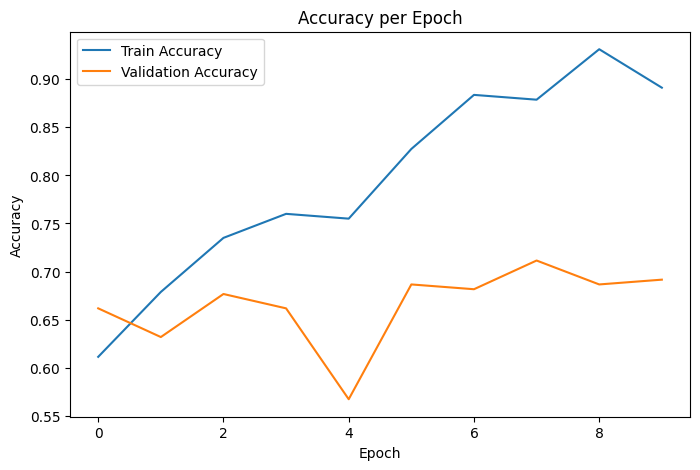

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history['acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

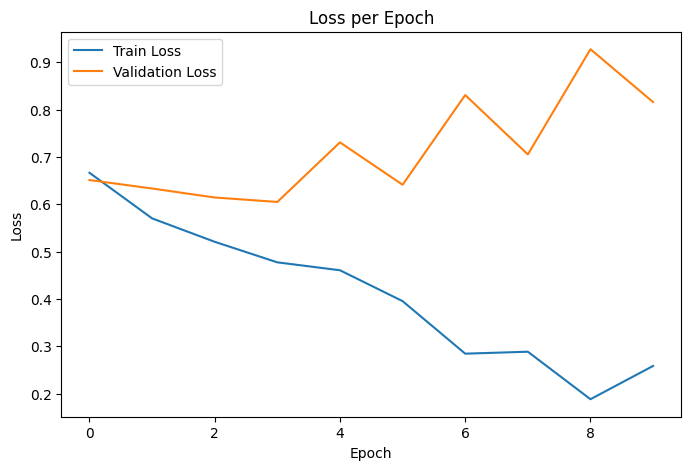

In [26]:
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

###**Data Augmentation**

In [27]:
# modify only the train transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [28]:
# reload the data
train_dataset = datasets.ImageFolder("/content/data/train", transform=train_transforms)

# load the dataloaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

# retrain the model
# training loop
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

Epoch 1/10, Loss: 0.6307, Acc: 0.6600, Val Loss: 0.5963, Val Acc: 0.7114
Epoch 2/10, Loss: 0.5801, Acc: 0.6750, Val Loss: 0.5968, Val Acc: 0.7214
Epoch 3/10, Loss: 0.5374, Acc: 0.7175, Val Loss: 0.5870, Val Acc: 0.7015
Epoch 4/10, Loss: 0.5502, Acc: 0.7125, Val Loss: 0.5695, Val Acc: 0.7264
Epoch 5/10, Loss: 0.5250, Acc: 0.7412, Val Loss: 0.6758, Val Acc: 0.6816
Epoch 6/10, Loss: 0.5141, Acc: 0.7612, Val Loss: 0.5764, Val Acc: 0.7313
Epoch 7/10, Loss: 0.5217, Acc: 0.7362, Val Loss: 0.5756, Val Acc: 0.6866
Epoch 8/10, Loss: 0.4888, Acc: 0.7588, Val Loss: 0.5724, Val Acc: 0.7214
Epoch 9/10, Loss: 0.4989, Acc: 0.7475, Val Loss: 0.5452, Val Acc: 0.7313
Epoch 10/10, Loss: 0.4663, Acc: 0.7688, Val Loss: 0.5619, Val Acc: 0.7164


In [29]:
mean_test_loss = np.mean(history['val_loss'])
mean_test_loss

np.float64(0.58569345893848)

In [30]:
# average of the test accuracy for the last 5 epochs
mean_test_acc = np.mean(history['val_acc'][-5:])
mean_test_acc

np.float64(0.717412935323383)

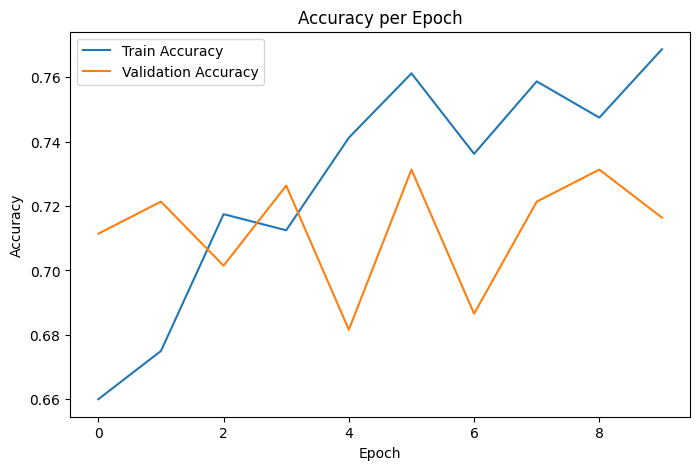

In [31]:
plt.figure(figsize=(8,5))
plt.plot(history['acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

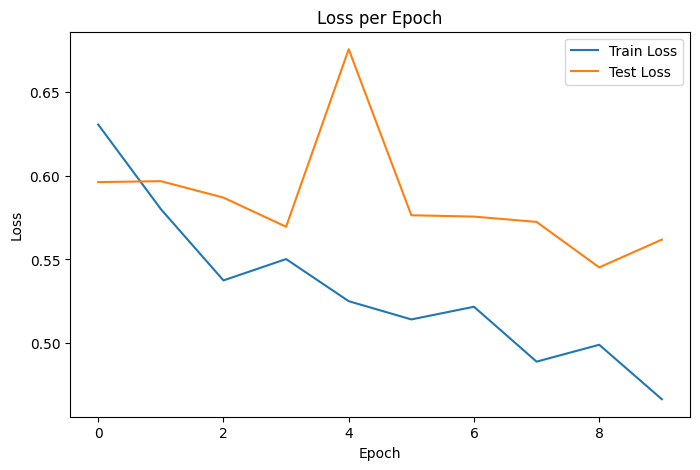

In [32]:
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()